<a href="https://colab.research.google.com/github/davide-ario/BNN/blob/main/BNN_gender_gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from warnings import filterwarnings
import h5py
#h5py.run_tests()

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
import tensorflow as tf

from sklearn import datasets
from sklearn.datasets import make_moons
#from scipy.special import comb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
print(f"Running on PyMC3 v{pm.__version__}")


Running on PyMC3 v3.11.4


In [3]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

Simulate data

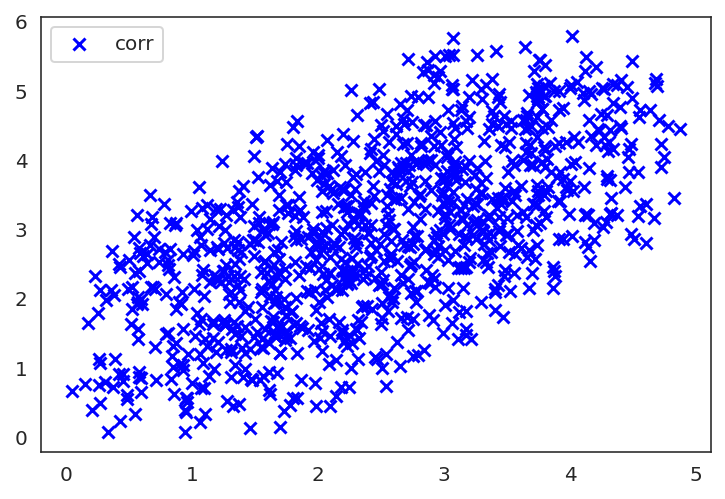

In [ ]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
latent =  np.random.rand(1000,)*3
X= np.random.rand(1000,5)*3
latent.mean(axis=0)
cofoundung_factor = np.random.rand(1000,)*3
X[:,0]= cofoundung_factor+np.random.rand(1000,)*2
latent_corr = cofoundung_factor+np.random.rand(1000,)*3
np.corrcoef(X[:,0], latent_corr)

fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X[:,0],latent_corr, c='b', marker='x', label='corr')
plt.legend(loc='upper left');
plt.show()


Define dependent variable

In [ ]:
Y = X[:,0]*3-2*X[:,1]**2+8*X[:,1]+7*X[:,2]-4*X[:,3]**3+3*np.sin(X[:,4])+np.random.normal(0, 2, 1000)+2+latent_corr
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [ ]:
Compute correlation

In [ ]:
import scipy.stats
r, p = scipy.stats.pearsonr(X[:,0], X[:,1])
np.corrcoef(X[:,0], X[:,1])
np.corrcoef(X[:,0], latent_corr)


array([[1.        , 0.61436907],
       [0.61436907, 1.        ]])

EStimate linear regression (misspecified function)

Finished [100%]: Average Loss = 2,065.6


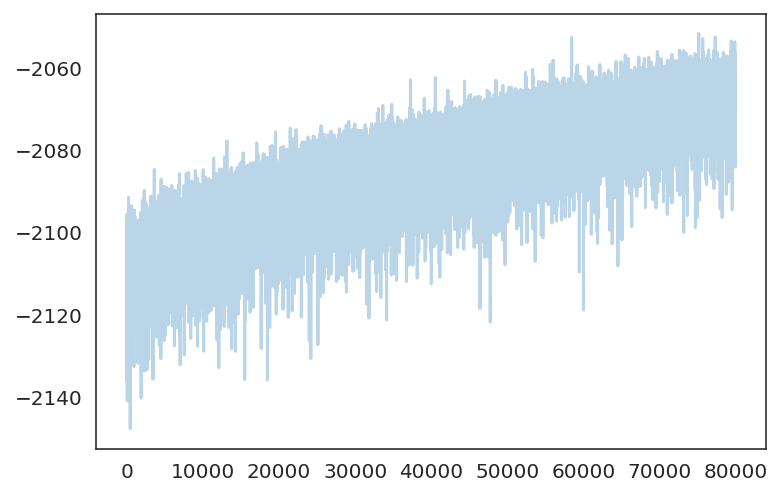

In [ ]:
#benchmark model
with pm.Model() as linear_regression:
    ann_input = pm.Data("ann_input", X_train)
    ann_output = pm.Data("ann_output", Y_train)
#        delta = pm.HalfCauchy('delta', 1)
    # Weights from input to hidden layer
    sigma = pm.HalfCauchy('sigma', 5)
    alpha = pm.Normal("alpha", 0, sigma=10)

    # Weights from 1st to 2nd layer
    beta = pm.Normal("beta", 0, sigma=10, shape=5)
#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
    # Weights from hidden layer to output

#    mu = alpha + pm.math.dot(ann_input[], beta)
    mu = alpha + ann_input[:,0]*beta[0]+ann_input[:,1]*beta[1]+ann_input[:,2]*beta[2]+ann_input[:,3]*beta[3]+ann_input[:,4]*beta[4]

    # Binary classification -> Bernoulli likelihood
    out = pm.Normal(
        "out", mu=mu,
        sigma=sigma,
        observed=ann_output,
        total_size=Y_train.shape[0])  # IMPORTANT for minibatches)

    
with linear_regression:
    inference = pm.ADVI()
    appr = pm.fit(n=180000, method=inference)

plt.plot(-inference.hist[100000:], label="new ADVI", alpha=0.3)
trace_linear = appr.sample(draws=5000)

Parameter value

In [ ]:
#pm.traceplot(trace_linear, varnames=["alpha", "beta"])
pm.summary(trace_linear,)


Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,24.268,0.693,23.028,25.627,0.010,0.007,4377.0,4411.0,NaN
beta[0],5.531,0.254,5.057,6.001,0.004,0.003,5038.0,4868.0,NaN
beta[1],-9.211,0.395,-10.001,-8.505,0.006,0.004,4908.0,5035.0,NaN
beta[2],7.988,0.402,7.214,8.701,0.006,0.004,4925.0,5017.0,NaN
beta[3],-31.679,0.384,-32.380,-30.926,0.005,0.004,5160.0,4900.0,NaN
beta[4],1.228,0.417,0.454,2.034,0.006,0.004,4967.0,4789.0,NaN
sigma,14.256,0.489,13.329,15.183,0.007,0.005,4898.0,4494.0,NaN


In [ ]:
Evaluate performance linear model

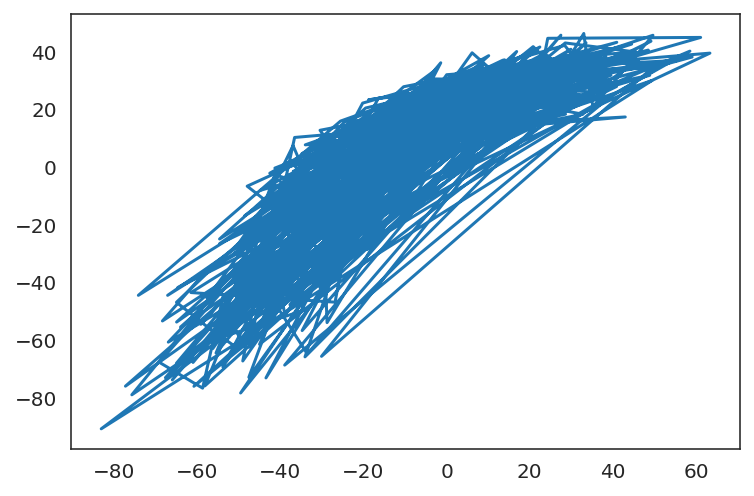

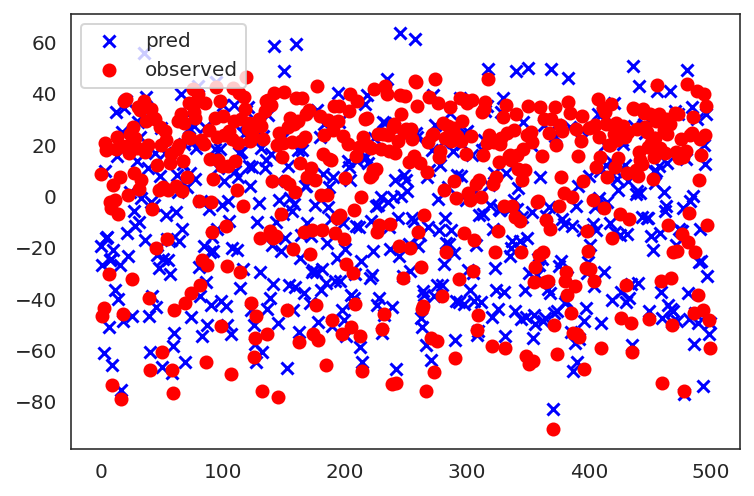

In [ ]:
pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=linear_regression)
ppc_linear = pm.sample_posterior_predictive(
    trace_linear, samples=500, progressbar=True, model=linear_regression
)

Y_pred_linear = ppc_linear["out"].mean(axis=0)
Y_pred_linear.mean(axis=0)
error_linear = (Y_test-Y_pred_linear)
plt.plot(Y_pred_linear, Y_test)
square_error_linear = (Y_test-Y_pred_linear)**2
error_linear.mean(axis=0)
square_error_linear.mean(axis=0)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)    
x = range(500)
ax1.scatter(x,Y_pred_linear, c='b', marker='x', label='pred')
ax1.scatter(x,Y_test, c='r', marker="o", label='observed')
plt.legend(loc='upper left');
plt.show()


Construct simple Bayesian Neural Network, with 2 hidden layer


In [ ]:


def construct_nn(ann_input, ann_output):
    n_hidden = 30

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)
        err = pm.Normal("err", 0, sigma=1)
        load1 = pm.Normal("load1", 0, sigma=1)
        load2 = pm.Normal("load2", 0, sigma=1)
        load3 = pm.Normal("load3", 0, sigma=1)

#        delta = pm.HalfCauchy('delta', 1)
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # Weights from hidden layer to output
        weights_2_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = T.nnet.relu(pm.math.dot(ann_input, weights_in_1))+load1*err
        act_2 = T.nnet.relu(pm.math.dot(act_1, weights_1_2))+load2*err
        act_3 = T.nnet.relu(pm.math.dot(act_2, weights_2_2))+load3*err
#        act_1 = T.dot(ann_input, weights_in_1)+err
#        act_2 = T.dot(act_1, weights_1_2)+err
#
#        act_3 = T.dot(act_2, weights_2_2)+err

#
#        act_1 = T.dot(ann_input, weights_in_1)
#        act_2 = T.dot(act_1, weights_1_2)
        

        act_out = T.dot(act_3, weights_2_out)+err

        # Binary classification -> Bernoulli likelihood
        out = pm.Normal(
            "out", mu=act_out,
            sigma=1,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network



In [ ]:
neural_network = construct_nn(X_train, Y_train)



Mini-batch estimation

In [ ]:
    
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)

with neural_network_minibatch:
  approx = pm.fit(120000, method=pm.ADVI())
    
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 13,968


Text(0.5, 0, 'iteration')

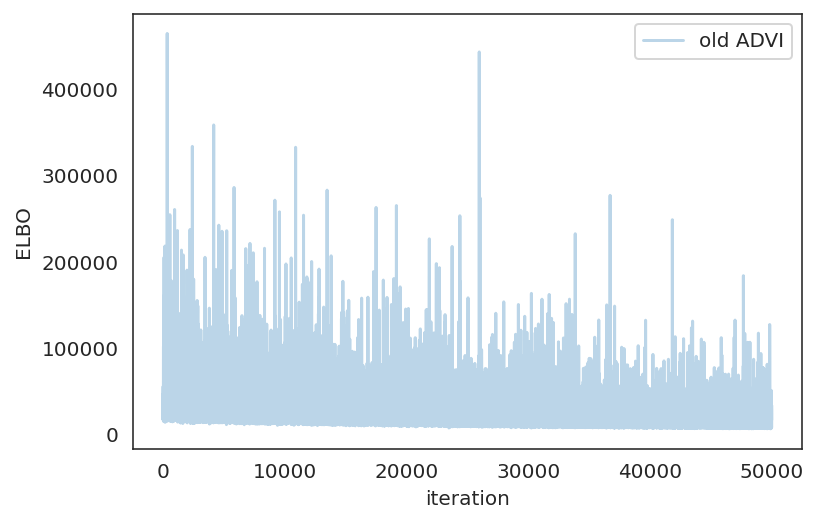

In [ ]:
#plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist[70000:], label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration")



Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
load1,1.010,0.005,1.001,1.021,0.000,0.000,5096.0,4981.0,NaN
load2,0.473,0.105,0.278,0.668,0.001,0.001,4961.0,4505.0,NaN
load3,-1.020,0.138,-1.280,-0.758,0.002,0.001,4796.0,4861.0,NaN


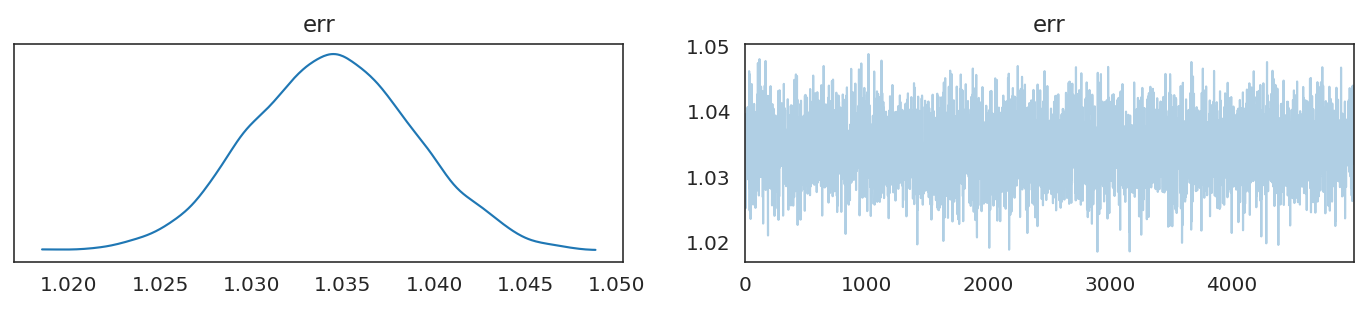

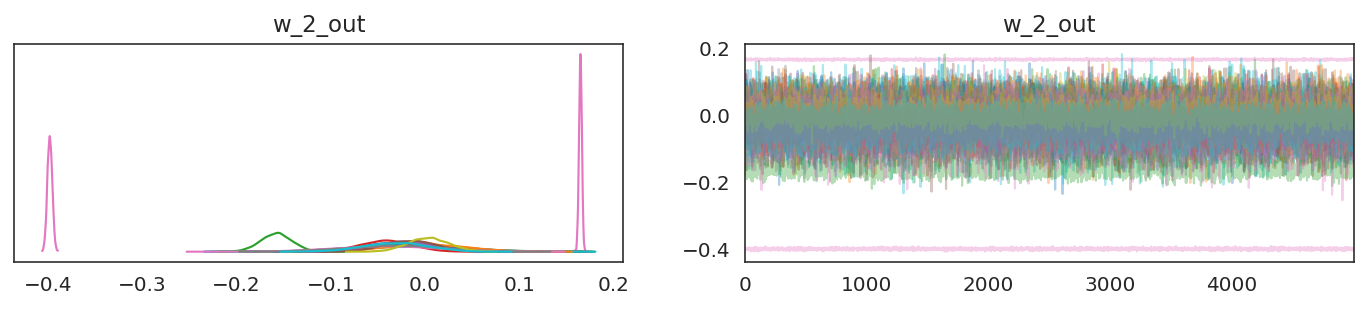

In [ ]:
trace = approx.sample(draws=5000)
pm.traceplot(trace, var_names="err")
pm.traceplot(trace, var_names="w_2_out")
pm.summary(trace, var_names=["load1","load2","load3"])


ValueError: ignored

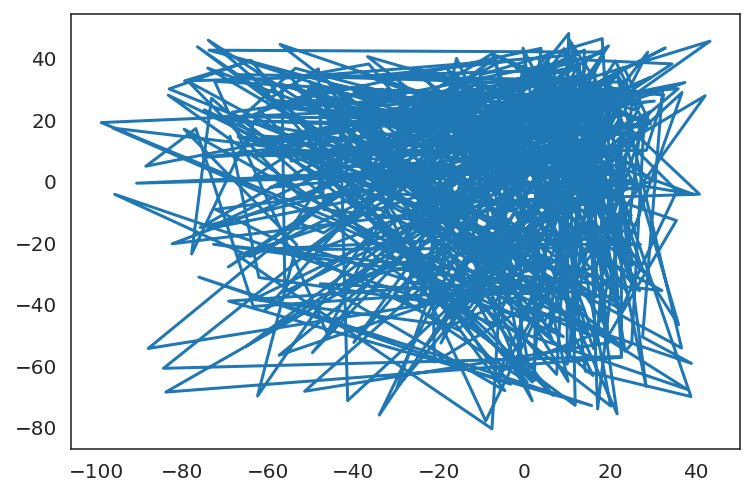

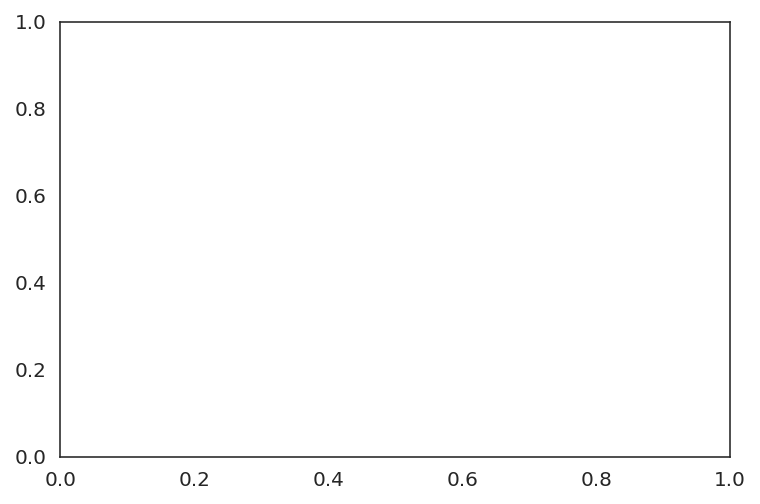

In [ ]:
    pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=neural_network_minibatch)
    ppc = pm.sample_posterior_predictive(
        trace, samples=500, progressbar=True, model=neural_network_minibatch
    )

   
    pred = ppc["out"].mean(axis=0)
    pred.mean(axis=0)
    error = (Y_train-pred)
    plt.plot(pred, Y_train)
    square_error = (Y_train-pred)**2
    error.mean(axis=0)
    square_error.mean(axis=0)
    Y_pred=pred
fig = plt.figure()
ax1 = fig.add_subplot(111)    
x = range(29000)
ax1.scatter(x,Y_train, c='r', marker="o", label='observed')
ax1.scatter(x,pred, c='b', marker='x', label='pred')
plt.legend(loc='upper left');
plt.show()


In [ ]:
a= Y_pred>0 
b=  Y_test>0
sum(a==b)
sum(( Y_pred>0 )== (Y_test>0))
sum(( Y_pred_linear>0 )== (Y_test>0))


366

In [ ]:
Compute the marginal impact of independent variables

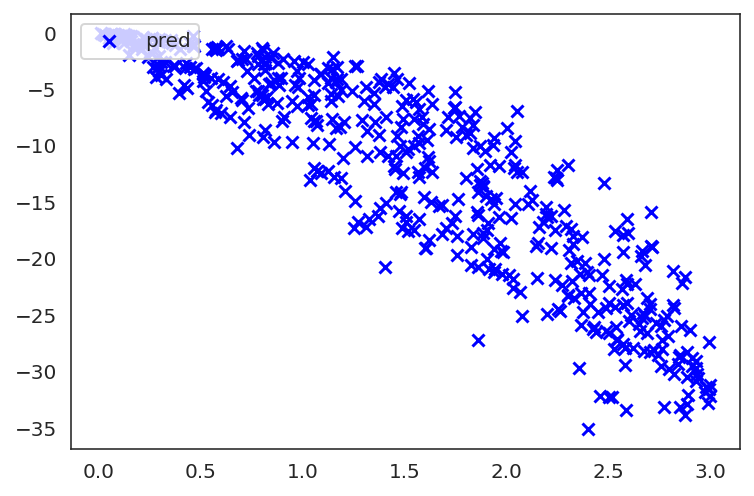

In [ ]:
#create counterfactual for training
# I want to capture the impact of X[0]
c=  np.array([1,0,1,1,1])
X_counter = X_train*c

#Y = X[:,0]*3-6*X[:,1]*X[:,1]+8*X[:,1]+np.random.normal(0, .2, 1000)+2+latent
X_counter = X_counter.astype(floatX)

pm.set_data(new_data={"ann_input": X_counter, "ann_output": Y_train}, model=neural_network_minibatch)
ppc_counter = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch, random_seed=132
)
pred_counter = ppc_counter["out"].mean(axis=0)
pred_counter.mean(axis=0)
Y_impact=Y_pred-pred_counter

##compute impact of x1
##compute fitted data
pm.set_data(new_data={"ann_input": X_train, "ann_output": Y_train}, model=neural_network_minibatch)
ppc_pred = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch, random_seed=132
)
Y_fitted = ppc_pred["out"].mean(axis=0)


pm.set_data(new_data={"ann_input": X_counter, "ann_output": Y_train}, model=neural_network_minibatch)
ppc_counter = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch, random_seed=132
)
pred_counter = ppc_counter["out"].mean(axis=0)
pred_counter.mean(axis=0)
Y_impact=Y_fitted-pred_counter



fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X_train[:,1],Y_impact, c='b', marker='x', label='pred')
plt.legend(loc='upper left');
plt.show()


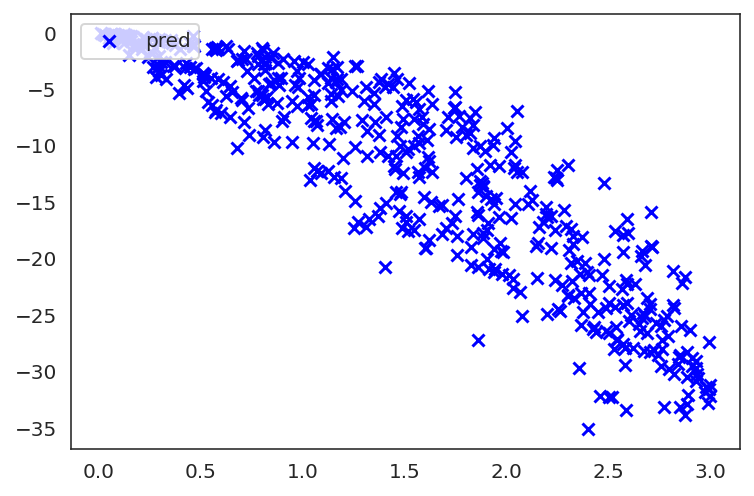

In [ ]:
ppc_eff=ppc_pred['out']-ppc_counter["out"]
impact= ppc_eff.mean(axis=0)
fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X_train[:,1],impact, c='b', marker='x', label='pred')
plt.legend(loc='upper left');
plt.show()


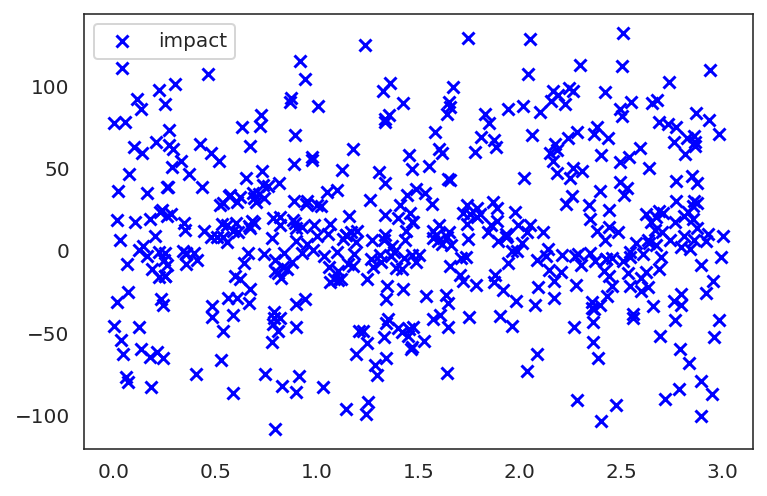

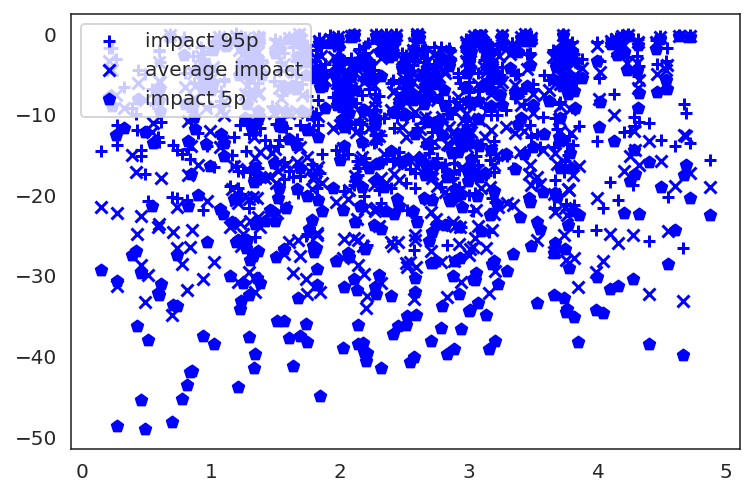

In [ ]:
##compute impact of x2
##compute fitted data
c=  np.array([0,1])


#create counterfactual for training
# I want to capture the impact of X[0]
c=np.ones((np.shape(X_train)[1],), dtype=int)
c[2,]=0
X_counter = X_train*c


#Y = X[:,0]*3-6*X[:,1]*X[:,1]+8*X[:,1]+np.random.normal(0, .2, 1000)+2+latent
X_counter = X_counter.astype(floatX)


pm.set_data(new_data={"ann_input": X_counter, "ann_output": Y_train}, model=neural_network_minibatch)
ppc_counter = pm.sample_posterior_predictive(
    trace, samples=500, progressbar=True, model=neural_network_minibatch
)
pred_counter = ppc_counter["out"].mean(axis=0)
pred_counter.mean(axis=0)
Y_impact=Y_pred-pred_counter
Y_impact.mean(axis=0)


fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X_train[:,2],Y_impact, c='b', marker='x', label='impact')
plt.legend(loc='upper left');
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)    
ax1.scatter(X_train[:,0],np.percentile(ppc_eff, 95, axis=0), c='b', marker='+', label='impact 95p')
ax1.scatter(X_train[:,0],np.percentile(ppc_eff, 50, axis=0), c='b', marker='x', label='average impact')
ax1.scatter(X_train[:,0],np.percentile(ppc_eff, 5, axis=0), c='b', marker='p', label='impact 5p')
plt.legend(loc='upper left');
plt.show()



NEURAL NETWORK WITH PARAMETRIC COMPONENT

In [ ]:
def construct_nnNEW(ann_input, ann_output):
    n_hidden = 30

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)
        err = pm.Normal("err", 0, sigma=1)
        load1 = pm.Normal("load1", 0, sigma=1)
        load2 = pm.Normal("load2", 0, sigma=1)
        load3 = pm.Normal("load3", 0, sigma=1)
        alpha = pm.Normal("alpha", 0, sigma=10)

        beta = pm.Normal("beta", 0, sigma=10, shape=2)
#              # Weights from 1st to 2nd layer


#        delta = pm.HalfCauchy('delta', 1)
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # Weights from hidden layer to output
        weights_2_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        mu_para= alpha + ann_input[:,0]*beta[0]+ann_input[:,1]*beta[1]

        act_1 = T.nnet.relu(pm.math.dot(ann_input, weights_in_1))+load1*err
        act_2 = T.nnet.relu(pm.math.dot(act_1, weights_1_2))+load2*err
        act_3 = T.nnet.relu(pm.math.dot(act_2, weights_2_2))+load3*err
#        act_1 = T.dot(ann_input, weights_in_1)+err
#        act_2 = T.dot(act_1, weights_1_2)+err
#
#        act_3 = T.dot(act_2, weights_2_2)+err

#
#        act_1 = T.dot(ann_input, weights_in_1)
#        act_2 = T.dot(act_1, weights_1_2)

        act_out = T.dot(act_3, weights_2_out)+err+mu_para

        # Binary classification -> Bernoulli likelihood
        out = pm.Normal(
            "out", mu=act_out,
            sigma=1,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network

minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nnNEW(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(100000, method=pm.ADVI())

trace = approx.sample(draws=5000)


Finished [100%]: Average Loss = 17,334


TypeError: ignored

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


KeyError: ignored

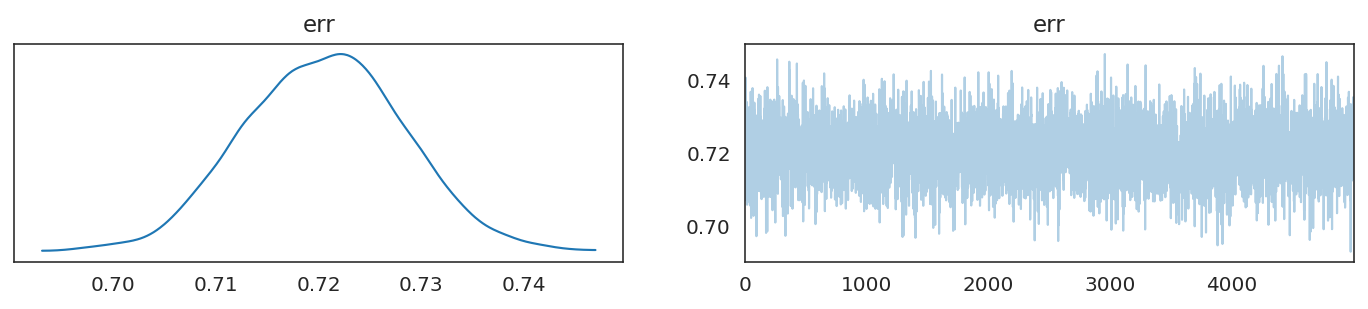

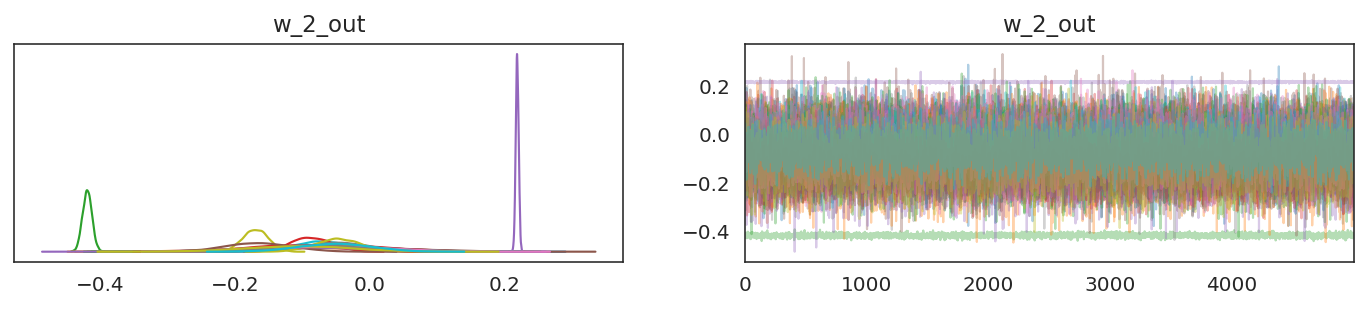

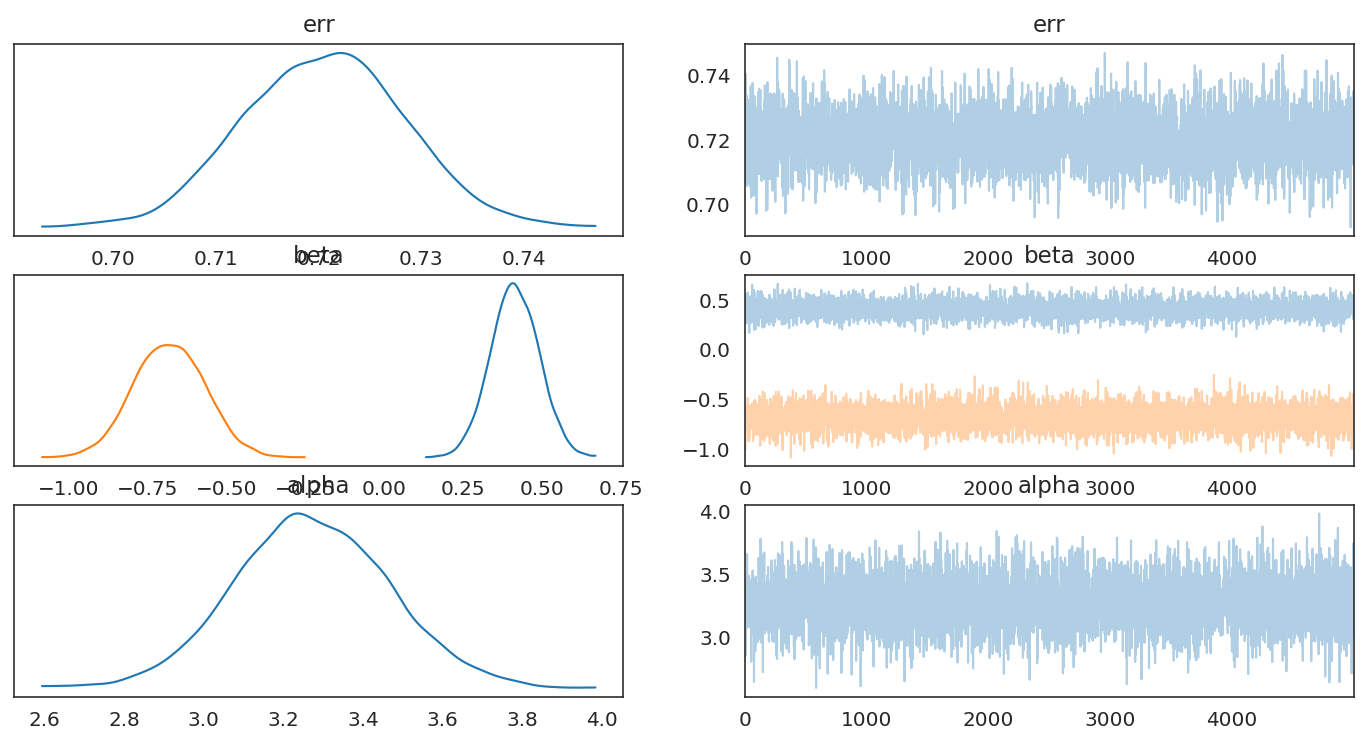

In [ ]:
trace = approx.sample(draws=5000)
pm.traceplot(trace, var_names="err")
pm.traceplot(trace, var_names="w_2_out")
pm.traceplot(trace, var_names=["err","beta","alpha"])
pm.summary(trace, var_names=["err","bias1","bias2","bias3"])


Nested Bayesian neural network with model selection. This BNN is made up by two different BNN. For each variable the BNN chose which model is more appropiate, applying a specific weight.

In [ ]:
def construct_nnNEW(ann_input, ann_output):
    n_hidden = 10

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
    init_b_1 = np.random.randn(n_hidden).astype(floatX)
    init_b_2 = np.random.randn(n_hidden).astype(floatX)
    init_b_3 = np.random.randn(n_hidden).astype(floatX)

    init_b_out = np.random.randn(1).astype(floatX)

#    init_1s = np.random.randn(X.shape[1], n_hidden).astype(floatX)
#    init_2s = np.random.randn(n_hidden, n_hidden).astype(floatX)
#    init_outs = np.random.randn(n_hidden).astype(floatX)
#    init_b_1s = np.random.randn(n_hidden).astype(floatX)
#    init_b_2s = np.random.randn(n_hidden).astype(floatX)
#    init_b_3s = np.random.randn(n_hidden).astype(floatX)
#
#    init_b_outs = np.random.randn(1).astype(floatX)






    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)
        err = pm.Normal("err", 0, sigma=1, shape=(X_train.shape[0],))
        errs = pm.Normal("errs", 0, sigma=1, shape=(X_train.shape[0],))

        model_sel=pm.Uniform('model_sel', lower=0, upper=1, shape=(X_train.shape[1],))
#        delta = pm.HalfCauchy('delta', 1)
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)
        bias1 = pm.Normal("bias1", 0, sigma=1, shape=n_hidden, testval=init_b_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias2 = pm.Normal("bias2", 0, sigma=1, shape=n_hidden, testval=init_b_2)

#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # Weights from hidden layer to output
        weights_2_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias3 = pm.Normal("bias3", 0, sigma=1, shape=n_hidden, testval=init_b_3)

        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
#        mu_para= alpha + ann_input[:,0]*beta[0]+ann_input[:,1]*beta[1]
        input_continuos = ann_input*(1-model_sel)
        act_1 = T.nnet.relu(pm.math.dot(input_continuos, weights_in_1)+bias1)
        act_2 = T.nnet.relu(pm.math.dot(act_1, weights_1_2)+bias2)
        act_3 = T.nnet.relu(pm.math.dot(act_2, weights_2_2)+bias3)
#        act_1 = T.dot(ann_input, weights_in_1)+err
#        act_2 = T.dot(act_1, weights_1_2)+err
#
#        act_3 = T.dot(act_2, weights_2_2)+err

#        # Build neural-network using tanh activation function

#        act_1 = T.dot(ann_input, weights_in_1)
#        act_2 = T.dot(act_1, weights_1_2)

        act_out = T.dot(act_3, weights_2_out)+err


#        errs = pm.Normal("errs", 0, sigma=1, shape=(X_train.shape[0],))

#        delta = pm.HalfCauchy('delta', 1)
        # Weights from input to hidden layer
        ##data to point
        
        ##
        weights_in_1s = pm.Normal("w_in_1s", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)
        bias1s = pm.Normal("bias1s", 0, sigma=1, shape=n_hidden, testval=init_b_1)

        # Weights from 1st to 2nd layer
        weights_1_2s = pm.Normal("w_1_2s", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias2s = pm.Normal("bias2s", 0, sigma=1, shape=n_hidden, testval=init_b_2)

#              # Weights from 1st to 2nd layer
#        weights_1_2 = pm.Normal("w_2_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # Weights from hidden layer to output
        weights_2_2s = pm.Normal("w_2_2s", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        bias3s = pm.Normal("bias3s", 0, sigma=1, shape=n_hidden, testval=init_b_3)

        weights_2_outs = pm.Normal("w_2_outs", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
#        mu_para= alpha + ann_input[:,0]*beta[0]+ann_input[:,1]*beta[1]
        input_discrete = ann_input*model_sel

        act_1s = pm.math.tanh(pm.math.dot(input_discrete, weights_in_1s)+bias1s)
        act_2s = pm.math.tanh(pm.math.dot(act_1s, weights_1_2s)+bias2s)
        act_3s = pm.math.tanh(pm.math.dot(act_2s, weights_2_2s)+bias3s)
#        act_1 = T.dot(ann_input, weights_in_1)+err
#        act_2 = T.dot(act_1, weights_1_2)+err
#
#        act_3 = T.dot(act_2, weights_2_2)+err

#        # Build neural-network using tanh activation function

#        act_1 = T.dot(ann_input, weights_in_1)
#        act_2 = T.dot(act_1, weights_1_2)

        act_outs = pm.math.sigmoid(pm.math.dot(act_3s, weights_2_outs)+errs)

        # Binary classification -> Bernoulli likelihood
        out = pm.Normal(
            "out", mu=act_out+act_outs,
            sigma=1,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network

minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nnNEW(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(120000, method=pm.ADVI())

trace = approx.sample(draws=5000)

pm.summary(trace, varnames=["model_sel"])

Finished [100%]: Average Loss = 4,429.2


TypeError: ignored

In [ ]:
pm.summary(trace, var_names=["model_sel"])

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_sel[0],0.747,0.002,0.743,0.751,0.0,0.0,4897.0,4847.0,NaN
model_sel[1],0.887,0.003,0.881,0.893,0.0,0.0,5093.0,4925.0,NaN
model_sel[2],0.712,0.002,0.707,0.716,0.0,0.0,4967.0,4781.0,NaN
model_sel[3],0.287,0.001,0.286,0.288,0.0,0.0,4660.0,4893.0,NaN
model_sel[4],0.932,0.005,0.923,0.940,0.0,0.0,4944.0,4715.0,NaN
